파이썬 머신러닝 완벽가이드 p147~p174

# CH03 평가(Evaluation)
- 성능 평가 지표(Evaluation Metric)은 일반적으로 모델이 분류냐 회귀냐에 따라 여러 종류도 나뉜다.
1. 회귀 : 실제값과 예측값의 오차 평균 값에 기반

2.  분류 (이진 분류와 멀티 분류)
> 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC

## 01. 정확도 (Accuracy)
- 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

- $\displaystyle 정확도 = \frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$

- 직관적으로 모델 예측 성능을 나타내는 평가 지표

- 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 성별에 따라 생존자를 예측하는 단순한 알고리즘
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메소드는 아무것도 학습하지 않음.
    def fit(self, X , y=None):
        pass

    # predict()  메소드는 단순히 Sex feature가 1이면 0 , 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( ( X.shape[0], 1 ))
        for i in range (X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1

        return pred

In [3]:
# 앞장의 타이타닉 데이터 내용 가져오기

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
titanic_df =pd.read_csv('/content/drive/MyDrive/ESAA/23-2/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=0)

# MyDummyClassifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test , mypredictions)))

Dummy Classifier의 정확도는: 0.7877


- 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구서에 따라 정확도의 결과가 높은 수치가 나올 수 있기에 정확도를 평가 지표로 사용할 때는 매우 신증해야 한다.
- 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

In [5]:
# 불균형한 데이터셋에 대해 정확도를 평가 지표로 사용할 때 발생하는 문제 살펴보기
# 레이블 값이 7인것만 True, 아닌건 모두 False로 멀티레이블을 이진 분류로 바꾼다.
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass

    # 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros((len(X),1) , dtype = bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 int 1로 변환, 7이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [6]:
# 불균형한 데이터로 생성한 y_test의 데이터 분포도를 확인하고 예측과 평가 수행
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 : {:.3f}'.format(accuracy_score(y_test ,fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 : 0.900


- np.zeros()로 모두 0으로 반환함에도 불구하고 예측 정확도는 90%이다.
- 정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다.

## 02 오차 행렬
- 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함꼐 보여주는 지표.
- 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지도 매핑되는지를 나타낸다.
- 왼쪽 오른쪽을 예측된 클래스 값을 기준으로, 위 아래를 실제 클래스 값을 기준으로 분류.
- TN,FP,FN,TP 형태로 오차 행렬의 4분면을 채운다.
- 예측 성능의 오류가 어떠한 모습으로 발생하는 지를 알 수 있다.


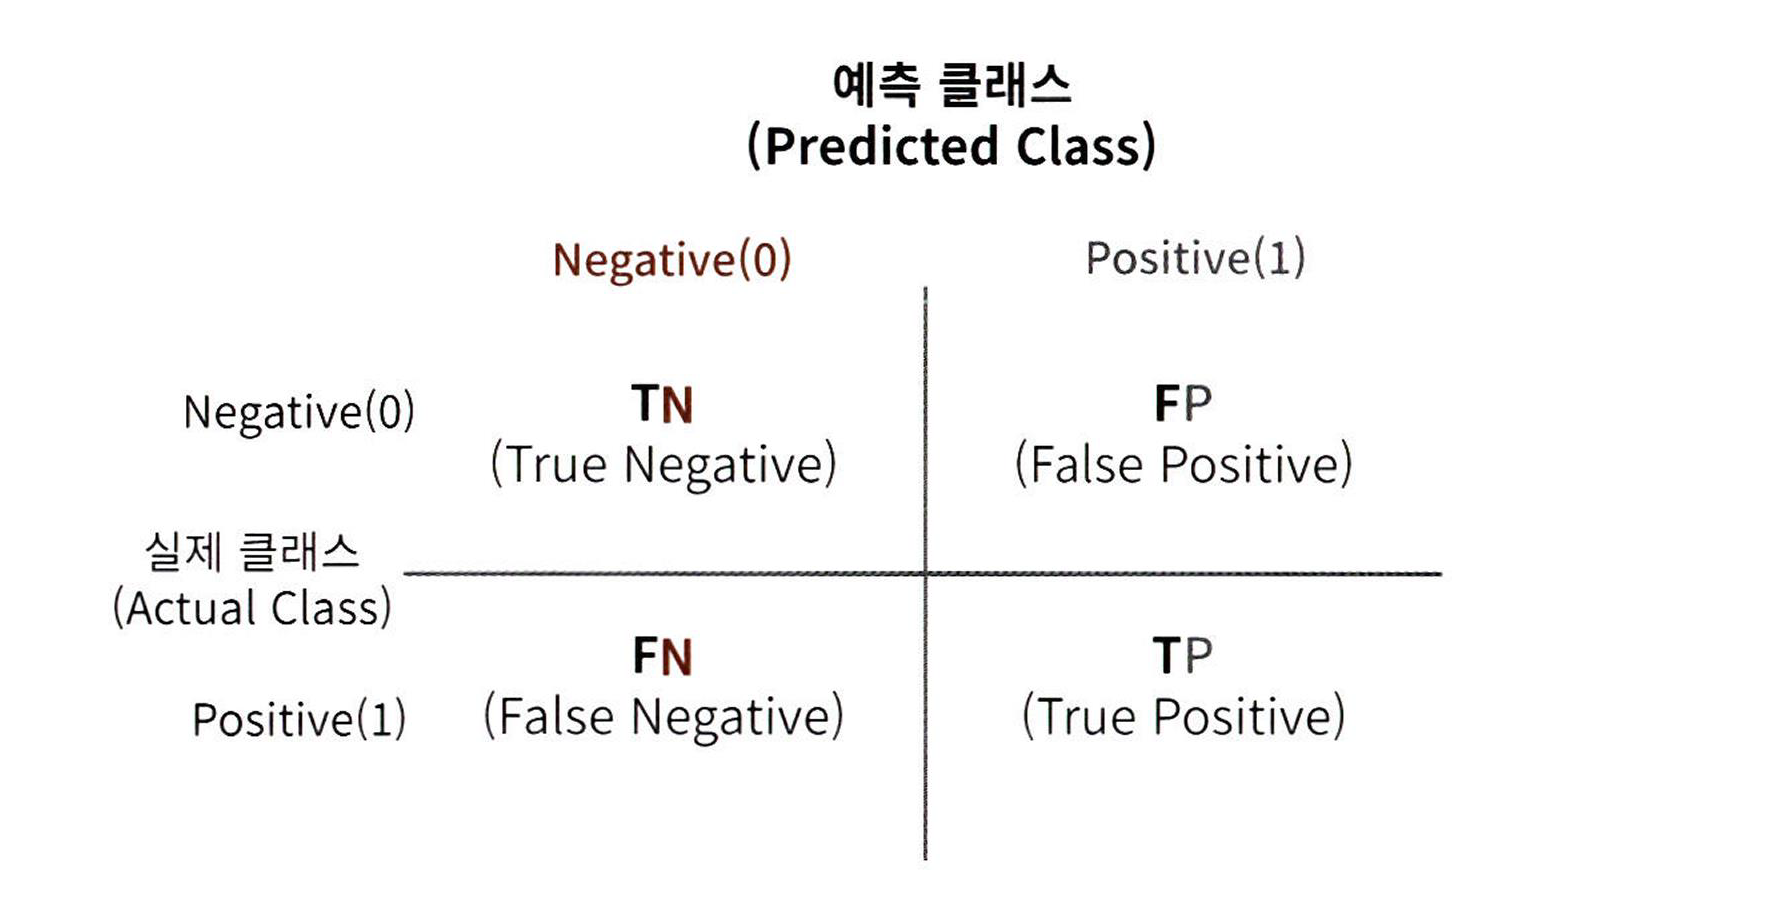

- 앞 문자는 실제 값이 같은가/틀린가 를 의미
- 뒷 문자는 예측 결과 값이 부정/긍정 을 의미
1. True Negative : 예측값을 Negative을 0으로 예측했고, 실제 값 역시 Negative 0
2. False Positive : 예측값을 Positive을 1으로 예측했지만, 실제 값은 Negative 0
3. False Negative : 예측값을 Negative을 0으로 예측했지만, 실제 값은 Positive 1
4. True Positive : 예측값을 Positive를 1으로 예측했고, 실제 값 역시 Positive 1

In [7]:
# 예측 결과 fakepred와 실제 결과인 y_test의 Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

- 정확도는 예측값과 실제값이 얼마나 동일한가에 대한 비율만으로 결정된다. 즉 오차 행렬에서 True에 해당하는 값인 TN과 TP에 좌우된다.
- **정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)**

## 03 정밀도와 재현율
- Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표.
- 불균형한 데이터 세트에서 정확도보다 더 선호되는 평가 지표.


1. **정밀도 = TP / (FP + TP)**
- Positive 한 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율
- 분모 : 예측을 Positive로 한 모든 데이터 건수
- 분자 : 예측과 실제 값이 Positive로 일치한 데이터 건수
- Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고도 불린다.
- **실제 Negative 데이터를 Positive 로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우에 중요한 지표임.**
- ex) 스팸메일 여부 판단 모델 : 실제 Negative인 일반 메일을 Positive인 스팸 메일로 분류할 경우

2. **재현율 = TP / (FN + TP)**
- 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
- 분모 : 실제 값이 Positive인 모든 데이터 건수
- 분자 : 예측 값과 실제 값이 Positive로 일치한 데이터 건수
- 민감도(Sensivity) 또는 TPR(True Positive Rate)라고도 불린다.
- **실제 Positive 데이터를 Negative 로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우에 중요한 지표임.**
- ex) 실제 positive인 암 환자를 negative로 잘못 판단하는 경우
- ex) 금융 사기 적발 모델 : 실제 금융 거래 사기인 Positive를 Negative로 잘못 판단하는 경우

-> 두 모델 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN(실제 P, 예측 N)을 낮추는데, 정밀도는 FP를 낮추는데 초점을 둔다.
- 이러한 특성때문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 적용된다.
- 두 지표 모두 높은 수치를 얻는 것이 좋다.

In [8]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

# confusion matrix, accuracy, precision, recall 등의 평가를 한번에 호출하는 함수
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/content/drive/MyDrive/ESAA/23-2/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

# 로지스틱 회귀모델
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# 성능 테스트
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드 오프
- 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우, 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.
- 정밀도/재현율 트레이드 오프 : 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 한쪽을 높이면 다른 하나는 떨어지기 쉽다.



사이킷런의 분류 알고리즘
- 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다.
- 그리고 예측 확률이 큰 레이블 값으로 예측한다.
- 일반적으로 이진 분류에서는 임곗값을 0.5로 정하고 이 기준보다 확률이 크면 Positive, 작으면 Negative로 결정한다.

predict_proba()
- 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드
- predict() 메서드와 유사하지만 단지 반환 결과가 예측 결과 클래스 값이 아닌 예측 확률 결과이다.

In [10]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46197474 0.53802526]
 [0.87872398 0.12127602]
 [0.87719492 0.12280508]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46197474 0.53802526 1.        ]
 [0.87872398 0.12127602 0.        ]
 [0.87719492 0.12280508 0.        ]]


- predict() 메서드 : predict_proba() 메서드에 기반해 생성된 API
- predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API

-> 이를 이해하는 것은 사이킷런이 어떻게 정밀도/재현율 트레이드오프를 구현했는지를 이해하는 데 도움을 준다.

In [11]:
# 사이킷런의 정밀도/재현율 트레이드오프을 이해

from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [12]:
# Binarizer를 이용해 사이킷런 predict()의 의사 코드 만들어보기
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


- 앞에서 predict() 로 계산괸 지표 값과 같다.

In [13]:
# 임계값 낮춰보기
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


임곗값을 낮추고 재현율이 올라가고 정밀도가 떨어진 이유
- 분류 결정 임계값은 positive 예측값을 결정하는 확률의 기준이 된다. 따라서 임계값을 낮출수록 True가 많아지게 된다.

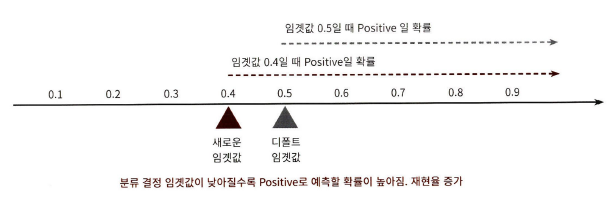

In [14]:
# 0.4부터 0.6까지 0.05씩 증가시키며 평가지표 조사
thresholds = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)
    print(' ')

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
 
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
 
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
 
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
 
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377
 


- 재현율을 향상시키면서 다른 수치를 어느정도만 감소하는 임계값 0.45가 가장 적당해보인다.

사이킷런은 precision_recall_curve() API를 제공한다.
- 입력 파라미터 : y_true(실제 클래스값 배열), provas_pred(배열 크기 = [데이터 건수])
- 반환값 : 정밀도, 재현율

In [15]:
# 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 구하기
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]    # 두 번째 칼럼 값에 해당하는 데이터 세트

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0],15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값: ',np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도: ',np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율: ',np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임곗값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임곗값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


- 임계값에 해당하는 정밀도 값과 재현율을 살펴보면 임계값이 증가할수록 정밀도 값은 동시에 높아지거나 재현율 값은 낮아짐을 알 수 있다.

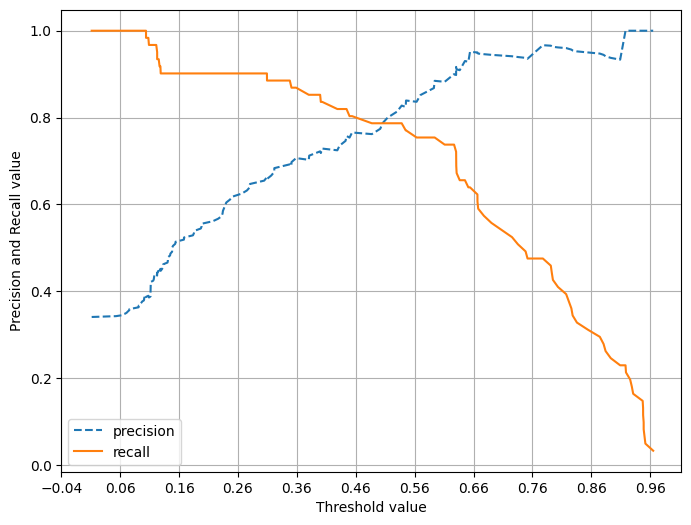

In [16]:
# 정밀도와 재현율의 임계값에 따른 변화를 곡선 형태의 그래프로 시각화 하는데 이용
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임곗값이 낮을수록 재현율 값이 높아지고 정밀도 값이 낮아진다. (양성 예측으로 인해)

### 정밀도와 재현율의 맹점
- Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치는 변경된다.


1. 정밀도가 100%가 되는 방법
- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
- ex) 환자는 80세 이상, 비만, 암 진단, 암 세포의 크기가 상위 0.1% 이상이면 Positive 로 예상 -> 한명만 P로 예측하더라도 FP = 0, TP = 1 이므로 정밀도는 항상 1/(1+0) 으로 100% 가 된다.

2. 재현율이 100%가 되는 방법
- 모든 환자를 Positive로 예측

## 04 F1 스코어
- 정밀도와 재현율을 결합한 지표
- F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐.
- $\displaystyle F1 = \frac{2}{
\displaystyle \frac{1}{recall}+\displaystyle \frac{1}{precision} } = 2* \frac{precision* recall}{precision + recall}$




In [17]:
# f1_score() API 사용
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [18]:
# 임곗값 0.4~0.6별로 정확도, 정밀도, 재현율, F1 스코어 알아보기
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
 
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
 
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
 
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
 
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036
 


- 스코어는 임계값이 0.6일 때 가장 좋은 값을 보여주지만, 이는 재현율이 크게 감소할 때이므로 주의

## 05 ROC 곡선과 AUC
- ROC(Receiver Operation Chararteristic Curve)는 우리 말로 수신자 판단 곡선
- FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)가 어떻게 변하는지를 나타내는 곡선
- FPR을 X 축으로, TPR을 Y 축으로 잡으면 FPR에 따른 TPR의 변화가 곡선 형태로 나타난다.

1. TPR  
- 재현율, 민감도
- TP/(FN+TP)
- 실제값 P가 정확히 예측돼야 하는 수준
2. TNR
- 특이성
- TN/(FP+TN)
- 실제값 N이 정확히 예측돼야 하는 수준
3. FPR
- ROC 곡선의 X축
- FP/(FP+TN)
- 1 - TNR
- 1 - 특이성



ROC 곡선
- 곡선이 가운데 직선에 가까울수록 성능이 떨어지고 멀어질수록 성능이 뛰어난 것임.
- 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구한다.
- FPR을 0부터 1까지 변경 : 분류 결정 임곘값 변경
- 분류 결정 임곗값 : Positive 예측값을 결정하는 확률의 기준
- FPR을 0으로 만들려면 : 임곗값을 1로 지정 (FP=0)
- FPR을 1로 만들려면 : 임곗값을 0으로 지정(TN=0)
- 이렇게 임곗값을 1부터 0까지 변화시키면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR 값을 구하는 것이 ROC 곡선임.

In [19]:
# roc_curve() API 사용

from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


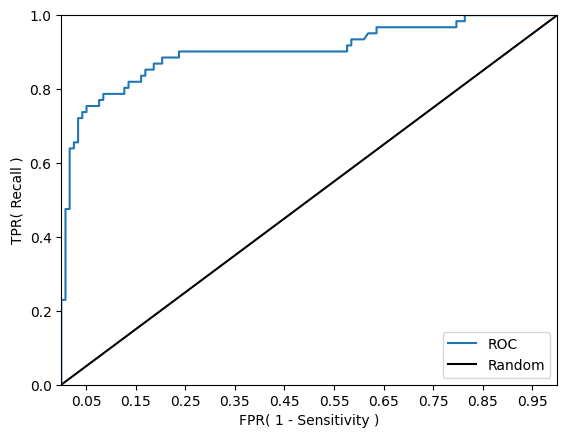

In [20]:
# ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환받음.
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림.
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림.
  plt.plot([0,1],[0,1],'k-',label='Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1);plt.ylim(0,1)
  plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

- AUC(Area Under Curve) : ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋음
- AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다.

In [22]:
# y_target이 없다.

'''
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print("정확도:",np.round(accuracy_score(y_target, preds),4))
print("정밀도:",np.round(precision_score(y_target, preds),4))
print("재현율:",np.round(recall_score(y_target, preds),4))
'''

' # y_target이 없다.\nfrom sklearn.metrics import accuracy_score, confusion_matrix, precision_score\nfrom sklearn.metrics import recall_score, f1_score, roc_auc_score\nimport numpy as np\n\nprint(confusion_matrix(y_target, preds))\nprint("정확도:",np.round(accuracy_score(y_target, preds),4))\nprint("정밀도:",np.round(precision_score(y_target, preds),4))\nprint("재현율:",np.round(recall_score(y_target, preds),4))\n'

In [23]:
# 정확도, 정밀도, 재현율, F1 스코어, ROC AUC 값까지 출력
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
  F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))